In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d shayanfazeli/heartbeat

 81% 80.0M/98.8M [00:00<00:00, 226MB/s]
100% 98.8M/98.8M [00:00<00:00, 195MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/heartbeat.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight, resample
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input,  Softmax, Add,  AveragePooling1D, ZeroPadding1D,Activation
from keras import backend as K
from keras.models import Model
from keras.initializers import glorot_uniform

In [ ]:
train_df=pd.read_csv('/content/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/mitbih_test.csv',header=None)

In [ ]:
train_df.shape

(87554, 188)

In [ ]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_df.shape

(21892, 188)

In [ ]:
train_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

In [ ]:
print(train_df[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


<AxesSubplot:xlabel='187', ylabel='count'>

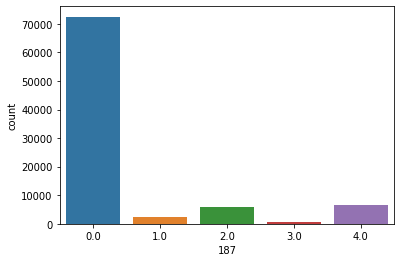

In [ ]:
sns.countplot(x=187, data = train_df) 

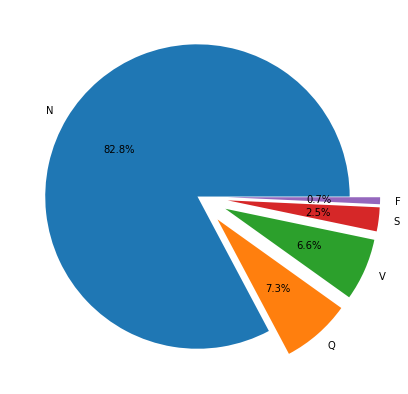

In [ ]:
plt.figure(figsize=(7,7))
explode = (0, 0.2,0.2,0.2,0.2)
plt.pie(train_df[187].value_counts(), labels=['N','Q','V','S','F'], autopct='%1.1f%%', explode=explode)
plt.show()

In [ ]:
x = train_df.drop(187,axis=1)
y = train_df[187].astype('int64')
print(x.shape)
print(y.shape)

#x_test = test_df.drop(187,axis=1)
#y_test = test_df[187].astype('int64')
#print(x_test.shape)
#print(y_test.shape)

(87554, 187)
(87554,)


In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x,y.values,random_state=42,stratify=y.values,shuffle=True,train_size=0.75)

In [ ]:
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)

The shape of training data :  (65665, 187) (65665,)
The shape of validation data :  (21889, 187) (21889,)


In [ ]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
#y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
x_train = np.expand_dims(x_train, 2)
x_val = np.expand_dims(x_val, 2)
#x_test = np.expand_dims(x_test, 2)
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)
#print("The shape of testing data : ",x_test.shape,y_test.shape)

The shape of training data :  (65665, 187, 1) (65665, 5)
The shape of validation data :  (21889, 187, 1) (21889, 5)


In [ ]:
Classes_index = {
    'N': 0, 
    'S': 1, 
    'V': 2, 
    'F': 3, 
    'Q': 4
}

In [ ]:
import keras
class Classifier_INCEPTION:
    def __init__(self, weights_directory, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=10, kernel_size=41, nb_epochs=25):
        self.weights_directory = weights_directory
        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                    strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = Conv1D(filters=self.nb_filters, kernel_size=1,
                        padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                            padding='same', use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = GlobalAveragePooling1D()(x)

        output_layer = Dense(nb_classes, activation='softmax')(gap_layer)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', 
                      optimizer=Adam(),
                      metrics=['accuracy', Precision(), Recall()])

        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                      factor=0.5, 
                                      patience=int(self.nb_epochs/20),
                                      min_lr=0.0001)
        
        file_path = os.path.join(self.weights_directory,"best_weights.h5")
        model_checkpoint = ModelCheckpoint(filepath=file_path, 
                                           monitor='val_accuracy',
                                           mode="max",
                                           save_best_only=True)
        
        early_stopping = EarlyStopping(monitor="val_accuracy", 
                                       mode="max", 
                                       verbose=1, 
                                       patience=int(self.nb_epochs/10))
        plotlosses = PlotLossesKeras()
        self.callbacks = [reduce_lr, model_checkpoint, early_stopping,plotlosses]
        return model

    def fit(self, x_train, y_train, x_val, y_val, class_weights=None):       
        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        start_time = time.time()
        hist = self.model.fit(x_train, y_train, 
                              batch_size=mini_batch_size, 
                              epochs=self.nb_epochs,
                              verbose=self.verbose, 
                              validation_data=(x_val, y_val), 
                              callbacks=self.callbacks)
        
        duration = time.time() - start_time
        keras.backend.clear_session()
        print("Model take {} S to train ".format(duration))
        return hist 

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.layers import Activation,Input,Concatenate, Add, \
                         GlobalAveragePooling1D,MaxPool1D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

weights_directory = "./"
inception = Classifier_INCEPTION(weights_directory, x_train.shape[1:], len(Classes_index.keys()), 1, 
                                 batch_size=256, build=True)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 187, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 187, 32)      1280        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 187, 32)      640         ['input_1[0][0]']                
                                                                                              

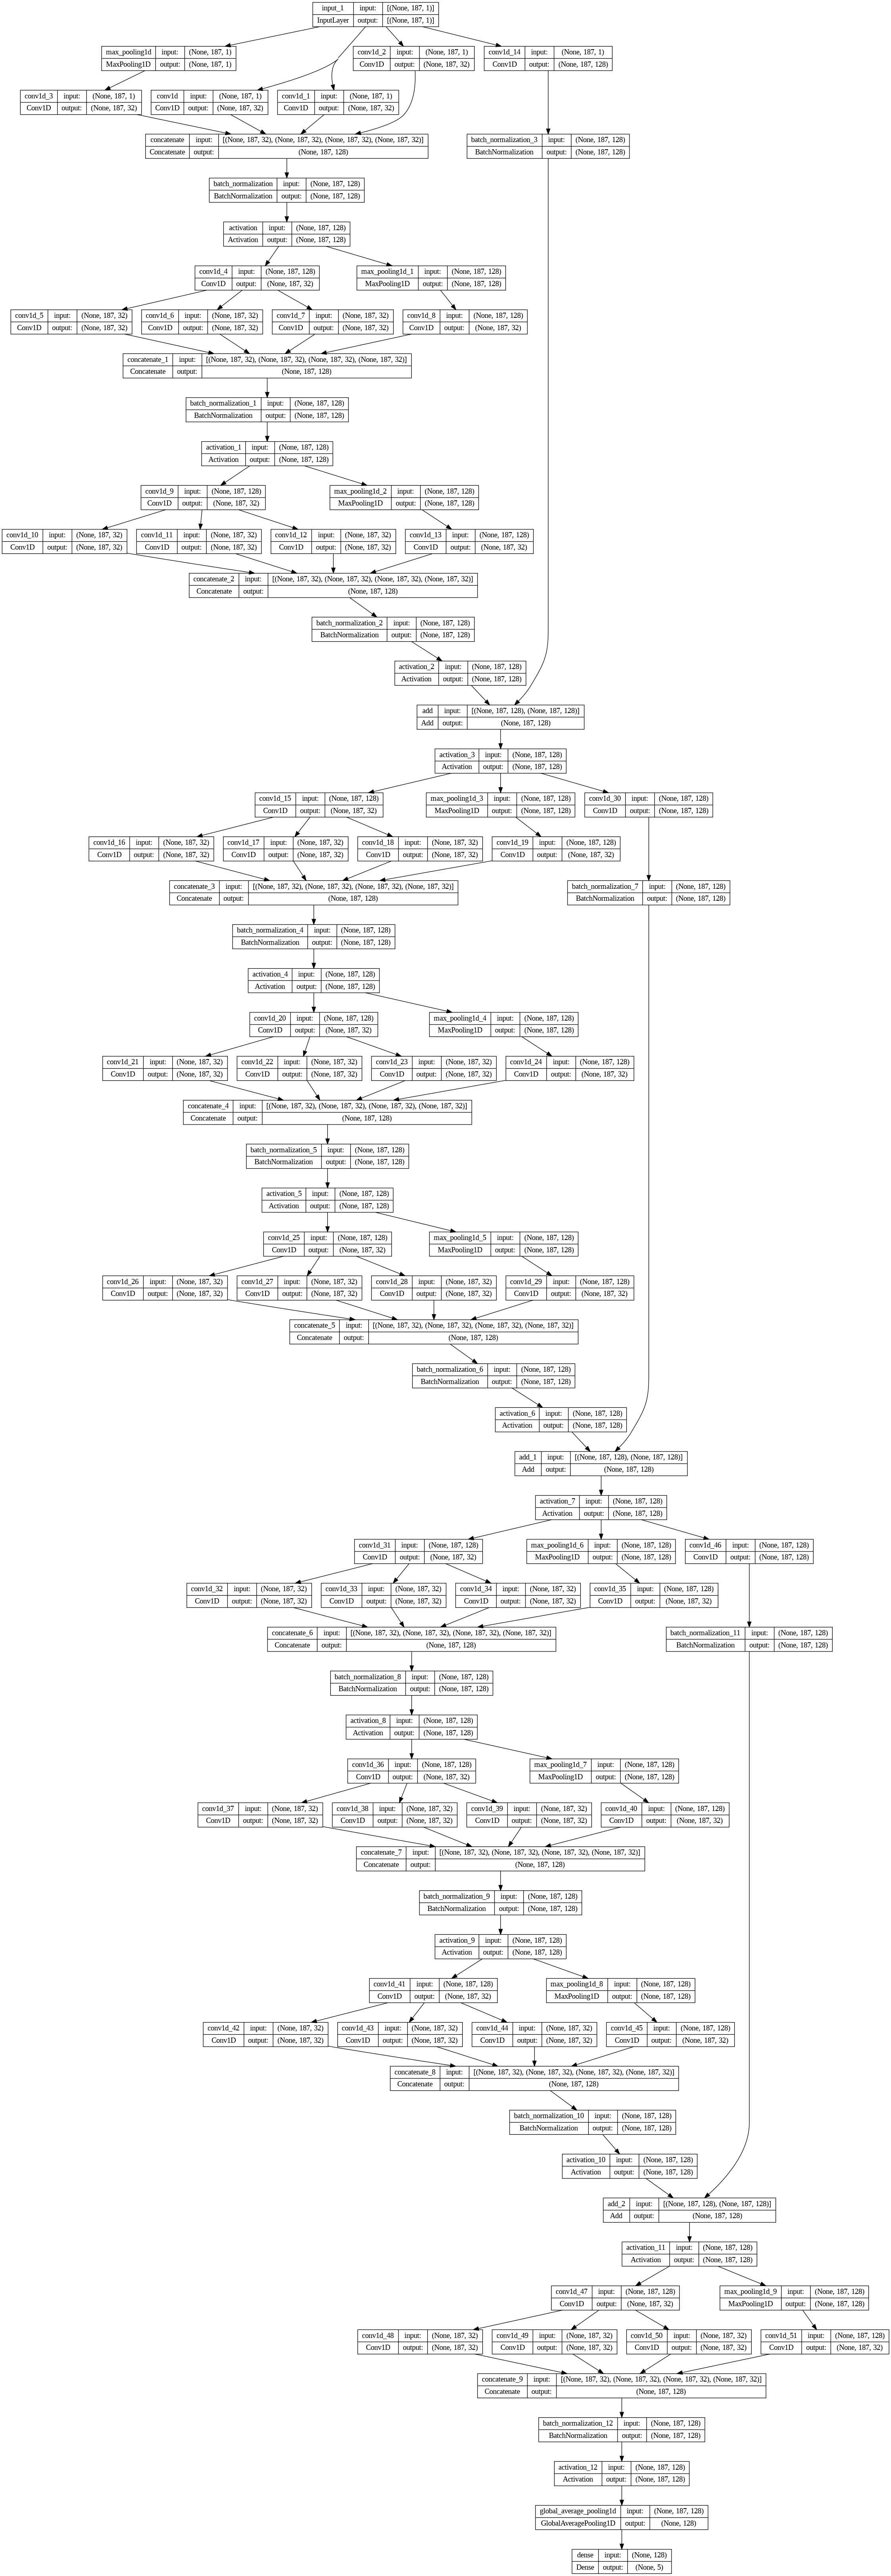

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(inception.model, show_shapes=True, show_layer_names=True)

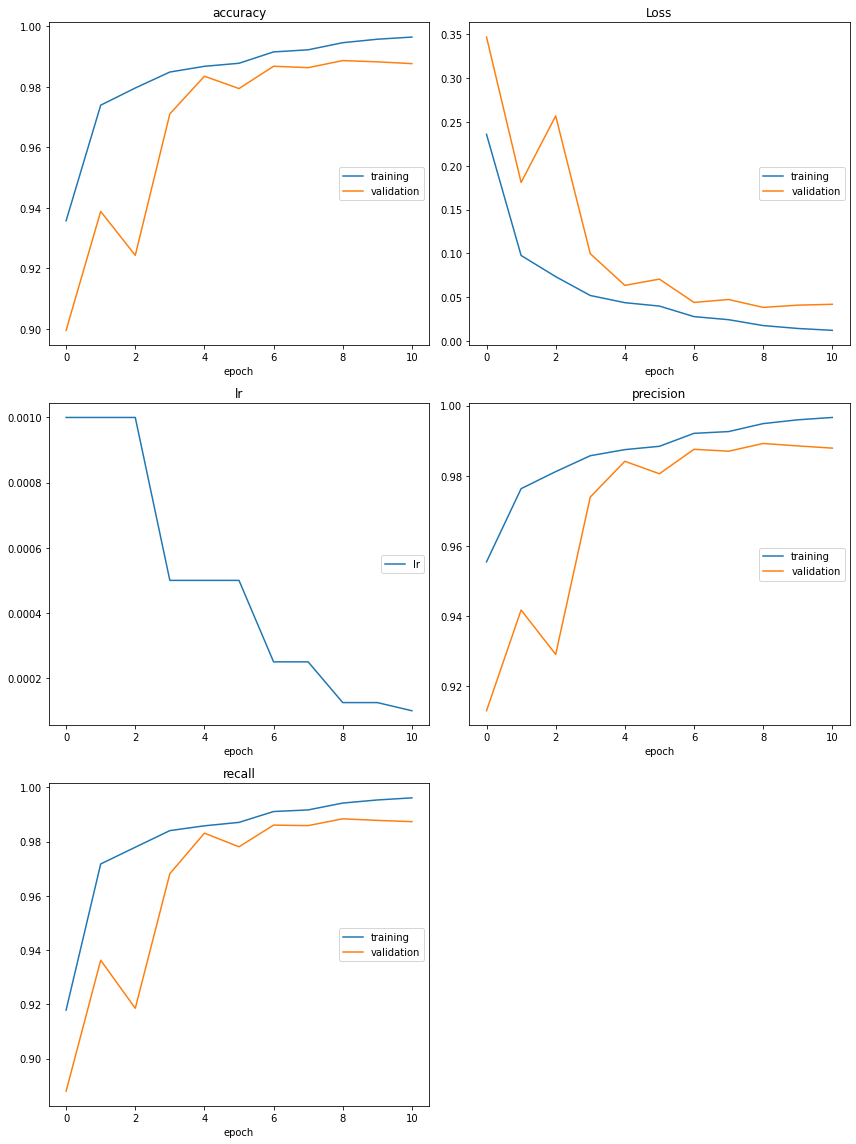

accuracy
	training         	 (min:    0.936, max:    0.996, cur:    0.996)
	validation       	 (min:    0.900, max:    0.989, cur:    0.988)
Loss
	training         	 (min:    0.012, max:    0.236, cur:    0.012)
	validation       	 (min:    0.038, max:    0.347, cur:    0.042)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
precision
	training         	 (min:    0.955, max:    0.997, cur:    0.997)
	validation       	 (min:    0.913, max:    0.989, cur:    0.988)
recall
	training         	 (min:    0.918, max:    0.996, cur:    0.996)
	validation       	 (min:    0.888, max:    0.988, cur:    0.987)
257/257 [==============================] - 50s 196ms/step - loss: 0.0122 - accuracy: 0.9964 - precision: 0.9966 - recall: 0.9962 - val_loss: 0.0419 - val_accuracy: 0.9876 - val_precision: 0.9879 - val_recall: 0.9874 - lr: 1.0000e-04
Epoch 11: early stopping
Model take 595.8753957748413 S to train 


In [ ]:
import time
history = inception.fit(x_train, y_train, x_val, y_val)

In [ ]:
inception.model.load_weights("./best_weights.h5")

<AxesSubplot:xlabel='187', ylabel='count'>

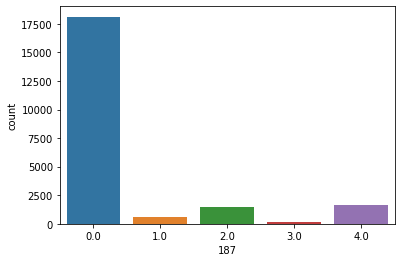

In [ ]:
classes = []
sns.countplot(x=187, data = test_df)

In [ ]:
print(test_df[187].value_counts())

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


In [ ]:
class_1 = test_df[test_df[187]==1.0]
class_2 = test_df[test_df[187]==2.0]
class_3 = test_df[test_df[187]==3.0]
class_4 = test_df[test_df[187]==4.0]
class_0 = test_df[test_df[187]==0.0].sample(n = 1400)

class_1=resample(class_1, replace=True, n_samples=600, random_state=1)
#class_2=resample(class_2, replace=True, n_samples=2000, random_state=1)
class_3=resample(class_3, replace=True, n_samples=500, random_state=1)
#class_4=resample(class_4, replace=True, n_samples=2000, random_state=1)

In [ ]:
new_test_df = pd.concat([class_0, class_1, class_2, class_3, class_4])

<AxesSubplot:xlabel='187', ylabel='count'>

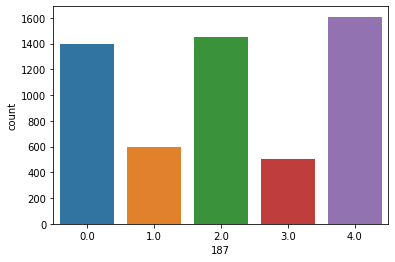

In [ ]:
sns.countplot(x=187, data = new_test_df) 

In [ ]:
x_test = new_test_df.drop(187,axis=1)
y_test = new_test_df[187].astype('int64')
print(x_test.shape)
print(y_test.shape)

(5556, 187)
(5556,)


In [ ]:
x_test = scaler.transform(x_test)

In [ ]:
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
x_test = np.expand_dims(x_test, 2)
print("The shape of testing data : ",x_test.shape,y_test.shape)

The shape of testing data :  (5556, 187, 1) (5556, 5)


In [ ]:
inception.model.evaluate(x_test, y_test)

174/174 [==============================] - 3s 13ms/step - loss: 0.2060 - accuracy: 0.9374 - precision: 0.9391 - recall: 0.9359


[0.2059677243232727,
 0.9373649954795837,
 0.9391367435455322,
 0.9359251260757446]

In [ ]:
from keras.models import load_model
best_model=load_model('/content/best_weights.h5')
results = best_model.evaluate(x_test,y_test, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.20597
Test Accuracy: 93.74%


Text(0, 0.5, 'accuracy')

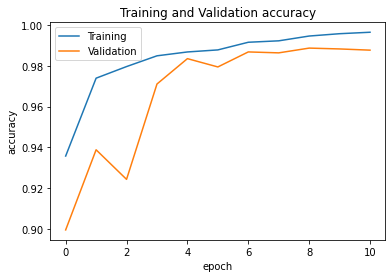

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

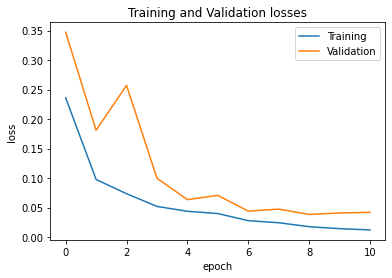

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

174/174 [==============================] - 3s 10ms/step


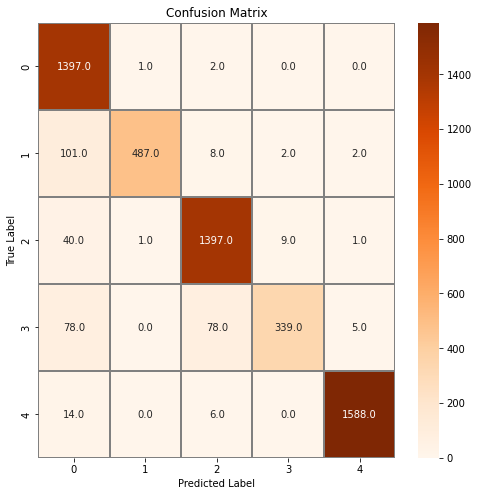

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

Y_pred = inception.model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1400
           1       1.00      0.81      0.89       600
           2       0.94      0.96      0.95      1448
           3       0.97      0.68      0.80       500
           4       0.99      0.99      0.99      1608

    accuracy                           0.94      5556
   macro avg       0.95      0.89      0.91      5556
weighted avg       0.94      0.94      0.94      5556



In [ ]:
CLASS_LABELS  = ['0', '1', '2', '3', '4']

ROC AUC score: 0.9945258833936913


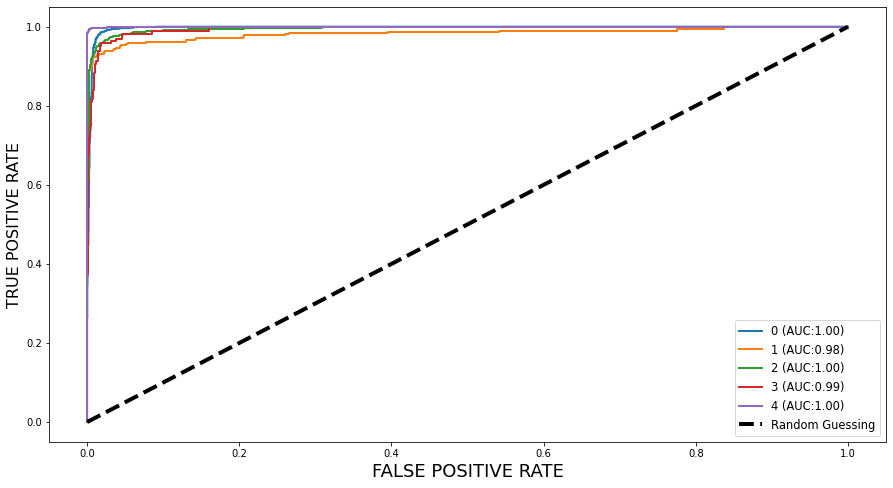

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , Y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
cnn = Sequential()
cnn.add(Conv1D(128,3,input_shape=(x_train.shape[1],1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,3, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,2, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,2, activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(5, activation='softmax'))

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 185, 128)          512       
                                                                 
 batch_normalization (BatchN  (None, 185, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 92, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 64)            24640     
                                                                 
 batch_normalization_1 (Batc  (None, 90, 64)           256       
 hNormalization)                                                 
                                                        

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='best_weights1.h5', monitor='val_loss', save_best_only=True)]

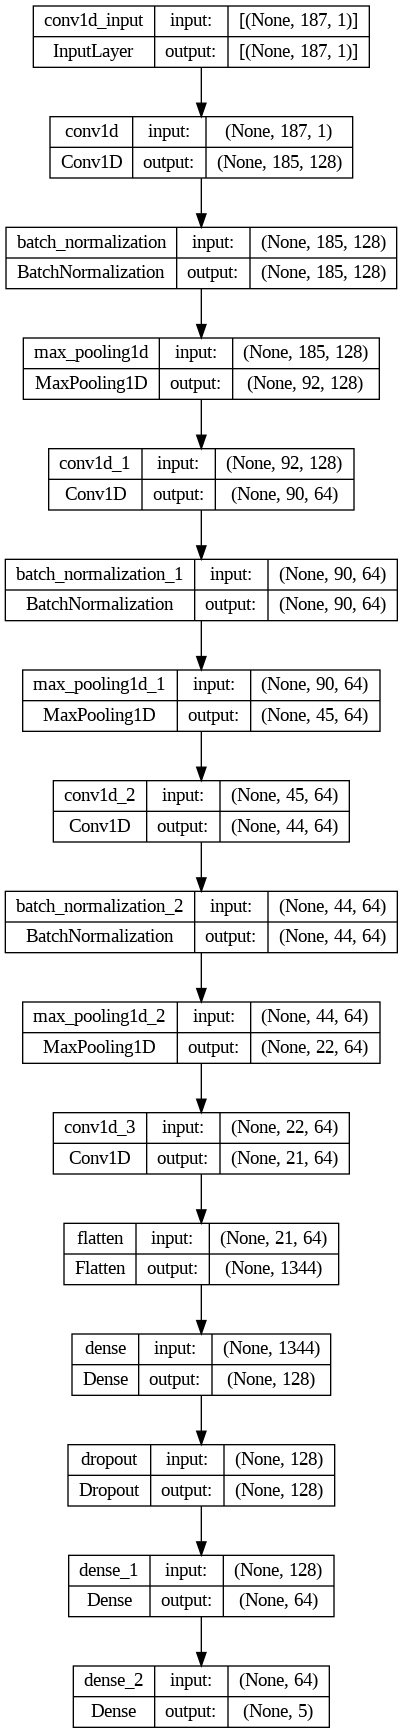

In [ ]:
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [ ]:
history=cnn.fit(x_train, y_train,epochs=20, callbacks=callbacks, batch_size=32, validation_data=(x_val,y_val))

Epoch 1/20
2053/2053 [==============================] - 23s 9ms/step - loss: 0.1885 - accuracy: 0.9507 - val_loss: 0.1035 - val_accuracy: 0.9718
Epoch 2/20
2053/2053 [==============================] - 18s 9ms/step - loss: 0.1134 - accuracy: 0.9695 - val_loss: 0.0865 - val_accuracy: 0.9752
Epoch 3/20
2053/2053 [==============================] - 18s 9ms/step - loss: 0.0914 - accuracy: 0.9749 - val_loss: 0.0778 - val_accuracy: 0.9783
Epoch 4/20
2053/2053 [==============================] - 19s 9ms/step - loss: 0.0796 - accuracy: 0.9762 - val_loss: 0.0661 - val_accuracy: 0.9808
Epoch 5/20
2053/2053 [==============================] - 18s 9ms/step - loss: 0.0697 - accuracy: 0.9802 - val_loss: 0.0799 - val_accuracy: 0.9772
Epoch 6/20
2053/2053 [==============================] - 19s 9ms/step - loss: 0.0639 - accuracy: 0.9820 - val_loss: 0.0660 - val_accuracy: 0.9810
Epoch 7/20
2053/2053 [==============================] - 18s 9ms/step - loss: 0.0563 - accuracy: 0.9831 - val_loss: 0.0590 - val_ac

In [ ]:
from keras.models import load_model
best_model=load_model('best_weights1.h5')
results = best_model.evaluate(x_test,y_test)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

174/174 [==============================] - 1s 5ms/step - loss: 0.2672 - accuracy: 0.9298
Test Loss: 0.26721
Test Accuracy: 92.98%


In [ ]:
results2 = cnn.evaluate(x_test,y_test, verbose=0)

print("     Test Loss: {:.5f}".format(results2[0]))
print(" Test Accuracy: {:.2f}%".format(results2[1] * 100))

     Test Loss: 0.31467
 Test Accuracy: 93.74%


<AxesSubplot:>

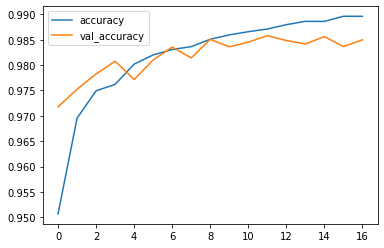

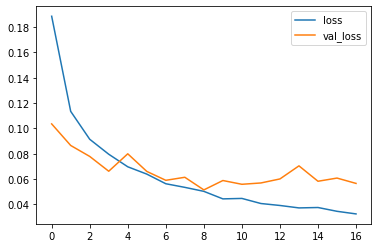

In [ ]:
pd.DataFrame(history.history)
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

174/174 [==============================] - 1s 3ms/step


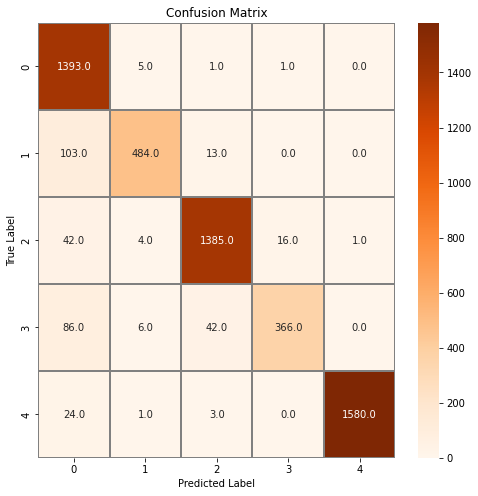

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = cnn.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1400
           1       0.97      0.81      0.88       600
           2       0.96      0.96      0.96      1448
           3       0.96      0.73      0.83       500
           4       1.00      0.98      0.99      1608

    accuracy                           0.94      5556
   macro avg       0.95      0.89      0.91      5556
weighted avg       0.94      0.94      0.94      5556



ROC AUC score: 0.9937125629301709


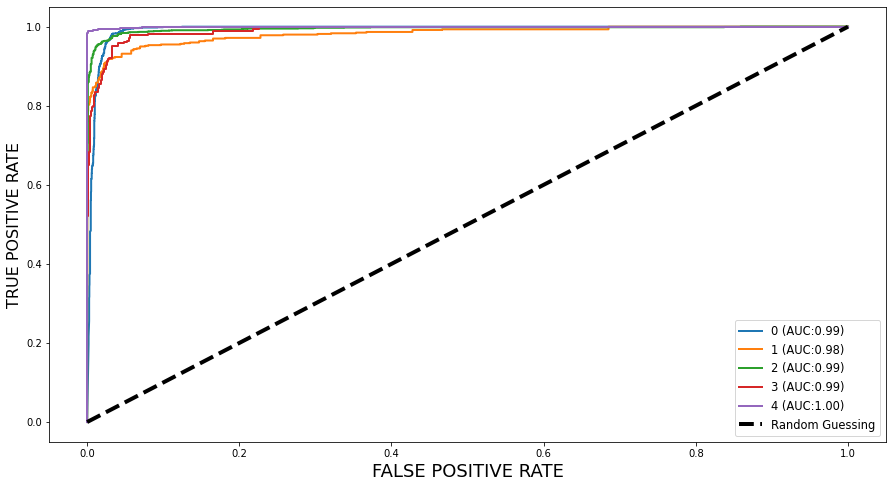

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , Y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
model1=load_model('/content/best_weights.h5')
model2=load_model('/content/best_weights1.h5')

In [ ]:
model1=Model(inputs=model1.inputs,outputs=model1.outputs,name='Inception')

In [ ]:
model2=Model(inputs=model2.inputs,outputs=model2.outputs,name='CNN')

In [ ]:
models=[model1,model2]

In [ ]:
preds=[model.predict(x_test) for model in models]

174/174 [==============================] - 1s 4ms/step


In [ ]:
preds=np.array(preds)

In [ ]:
summed=np.sum(preds,axis=0)

In [ ]:
ensemble_prediction=np.argmax(summed,axis=1)

In [ ]:
ensemble_accuracy=accuracy_score(Y_true,ensemble_prediction)

In [ ]:
print(ensemble_accuracy)

0.9400647948164147


In [ ]:
print(classification_report(Y_true,ensemble_prediction))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1400
           1       0.99      0.79      0.88       600
           2       0.95      0.96      0.96      1448
           3       0.98      0.73      0.84       500
           4       1.00      0.99      0.99      1608

    accuracy                           0.94      5556
   macro avg       0.95      0.89      0.92      5556
weighted avg       0.95      0.94      0.94      5556



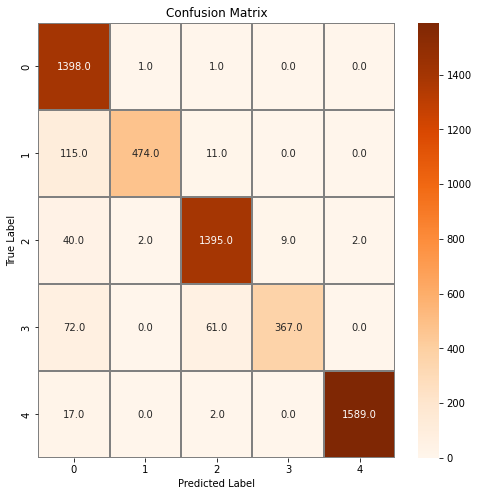

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(Y_true,ensemble_prediction) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ROC AUC score: 0.9948935524142949


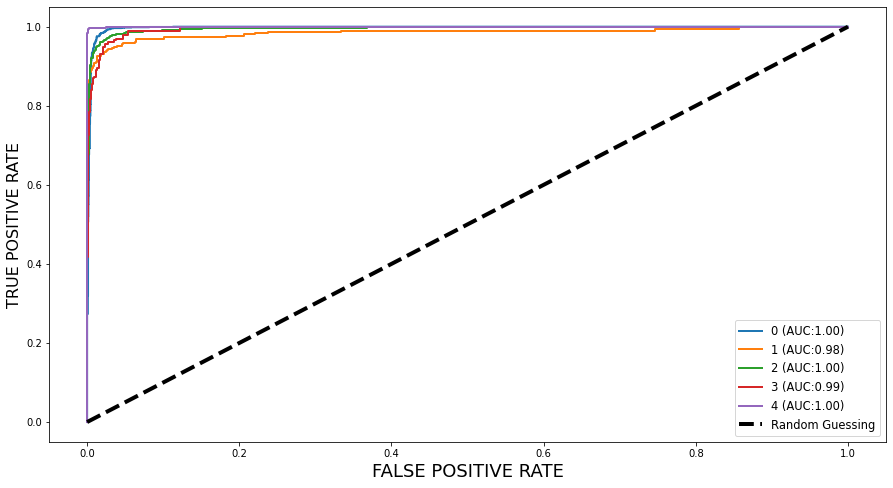

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , summed  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
model_input=Input(shape=(x_train.shape[1],1))

In [ ]:
model_outputs=[model(model_input) for model in models]

In [ ]:
from tensorflow.keras.layers import Input, Average,Maximum,Add
ensemble_output=Average()(model_outputs)

In [ ]:
ensemble_model=Model(inputs=model_input,outputs=ensemble_output,name='ensemble')

In [ ]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 Inception (Functional)         (None, 5)            761317      ['input_2[0][0]']                
                                                                                                  
 CNN (Functional)               (None, 5)            223429      ['input_2[0][0]']                
                                                                                                  
 average (Average)              (None, 5)            0           ['Inception[0][0]',              
                                                                  'CNN[0][0]']             

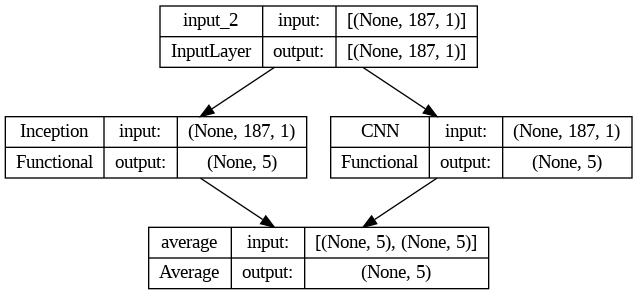

In [ ]:
plot_model(ensemble_model, show_shapes=True, show_layer_names=True)

In [ ]:
'''import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_weights3.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)'''

"import keras\ncheckpoint = keras.callbacks.ModelCheckpoint(\n    filepath='best_weights3.h5',\n    save_weights_only=False,\n    monitor='val_accuracy',\n    mode='max',\n    save_best_only=True,\n    verbose=1)"

In [ ]:
ensemble_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#callbacks1 = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='best_weights4.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
history=ensemble_model.fit(x_train, y_train,epochs=20,callbacks=callbacks, batch_size=32, validation_data=(x_val,y_val))

Epoch 1/20
2053/2053 [==============================] - 128s 51ms/step - loss: 0.0422 - accuracy: 0.9859 - val_loss: 0.0672 - val_accuracy: 0.9853
Epoch 2/20
2053/2053 [==============================] - 92s 45ms/step - loss: 0.0413 - accuracy: 0.9876 - val_loss: 0.0672 - val_accuracy: 0.9854
Epoch 3/20
2053/2053 [==============================] - 95s 46ms/step - loss: 0.0395 - accuracy: 0.9873 - val_loss: 0.0708 - val_accuracy: 0.9842
Epoch 4/20
2053/2053 [==============================] - 96s 47ms/step - loss: 0.0392 - accuracy: 0.9882 - val_loss: 0.0646 - val_accuracy: 0.9854
Epoch 5/20
2053/2053 [==============================] - 91s 45ms/step - loss: 0.0366 - accuracy: 0.9890 - val_loss: 0.0641 - val_accuracy: 0.9848
Epoch 6/20
2053/2053 [==============================] - 95s 46ms/step - loss: 0.0349 - accuracy: 0.9893 - val_loss: 0.0640 - val_accuracy: 0.9858
Epoch 7/20
2053/2053 [==============================] - 92s 45ms/step - loss: 0.0347 - accuracy: 0.9901 - val_loss: 0.0629 

In [ ]:
from keras.models import load_model
results1 = ensemble_model.evaluate(x_test,y_test)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

174/174 [==============================] - 2s 13ms/step - loss: 0.3270 - accuracy: 0.9325
    Test Loss: 0.32704
Test Accuracy: 93.25%


In [ ]:
best_model4=load_model('/content/best_weights1.h5')
results4 = best_model4.evaluate(x_test,y_test)

print("    Test Loss: {:.5f}".format(results4[0]))
print("Test Accuracy: {:.2f}%".format(results4[1] * 100))

174/174 [==============================] - 1s 4ms/step - loss: 0.2672 - accuracy: 0.9298
    Test Loss: 0.26721
Test Accuracy: 92.98%


Text(0, 0.5, 'loss')

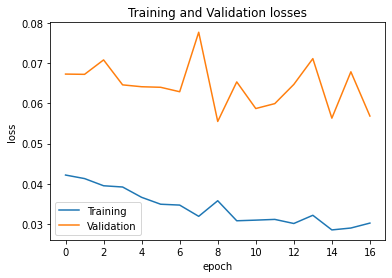

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

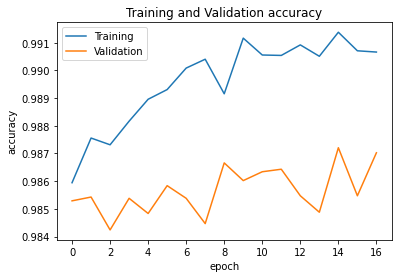

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

174/174 [==============================] - 3s 9ms/step


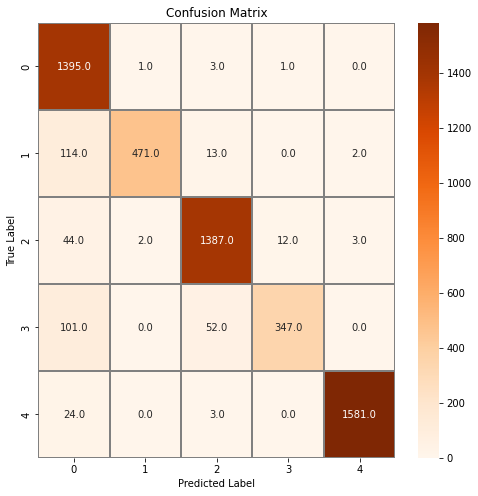

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = ensemble_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1400
           1       0.99      0.79      0.88       600
           2       0.95      0.96      0.95      1448
           3       0.96      0.69      0.81       500
           4       1.00      0.98      0.99      1608

    accuracy                           0.93      5556
   macro avg       0.95      0.88      0.91      5556
weighted avg       0.94      0.93      0.93      5556



ROC AUC score: 0.9930449907959847


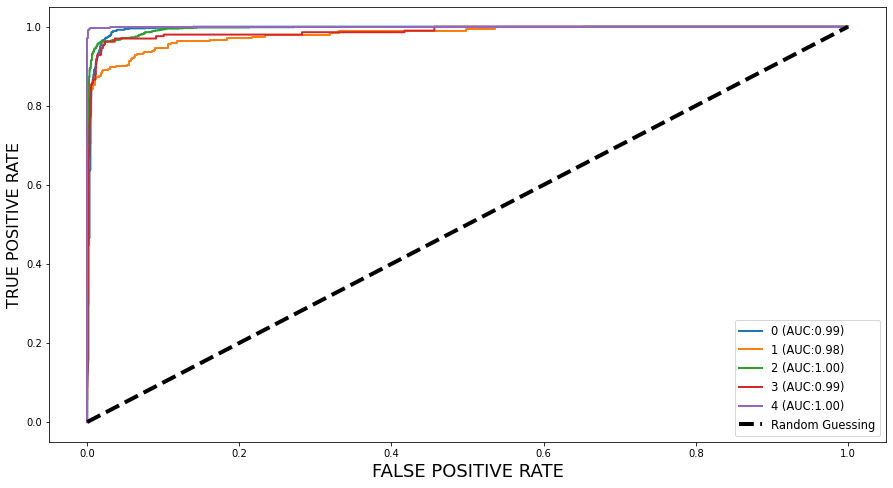

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , Y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
import math
from keras.callbacks import Callback
from keras import backend
from keras.models import load_model

# this callback applies cosine annealing, saves snapshots and allows to load them
class SnapshotEnsemble(Callback):
    
    __snapshot_name_fmt = "snapshot_%d.hdf5"
    
    def __init__(self, n_models, n_epochs_per_model, lr_max, verbose=1):
        """
        n_models -- quantity of models (snapshots)
        n_epochs_per_model -- quantity of epoch for every model (snapshot)
        lr_max -- maximum learning rate (snapshot starter)
        """
        self.n_epochs_per_model = n_epochs_per_model
        self.n_models = n_models
        self.n_epochs_total = self.n_models * self.n_epochs_per_model
        self.lr_max = lr_max
        self.verbose = verbose
        self.lrs = []
 
    # calculate learning rate for epoch
    def cosine_annealing(self, epoch):
        cos_inner = (math.pi * (epoch % self.n_epochs_per_model)) / self.n_epochs_per_model
        return self.lr_max / 2 * (math.cos(cos_inner) + 1)

    # when epoch begins update learning rate
    def on_epoch_begin(self, epoch, logs={}):
        # update learning rate
        lr = self.cosine_annealing(epoch)
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrs.append(lr)

    # when epoch ends check if there is a need to save a snapshot
    def on_epoch_end(self, epoch, logs={}):
        if (epoch + 1) % self.n_epochs_per_model == 0:
            # save model to file
            filename = self.__snapshot_name_fmt % ((epoch + 1) // self.n_epochs_per_model)
            self.model.save(filename)
            if self.verbose:
                print('Epoch %d: snapshot saved to %s' % (epoch, filename))
                
    # load all snapshots after training
    def load_ensemble(self):
        models = []
        for i in range(self.n_models):
            models.append(load_model(self.__snapshot_name_fmt % (i + 1)))
        return models

In [ ]:
se_callback = SnapshotEnsemble(n_models=4, n_epochs_per_model=5, lr_max=.001)

history = ensemble_model.fit(
    x_train, y_train,
    steps_per_epoch=len(x_train) / 64,
    epochs=se_callback.n_epochs_total,
    verbose=1,
    callbacks=[se_callback],
    validation_data=(x_test, y_test)
)

Epoch 1/20
1026/1026 [==============================] - 87s 84ms/step - loss: 0.0821 - accuracy: 0.9921 - val_loss: 0.6346 - val_accuracy: 0.9305
Epoch 2/20
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0800 - accuracy: 0.9927 - val_loss: 0.6196 - val_accuracy: 0.9294
Epoch 3/20
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0780 - accuracy: 0.9935 - val_loss: 0.6545 - val_accuracy: 0.9267
Epoch 4/20
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0760 - accuracy: 0.9948 - val_loss: 0.6502 - val_accuracy: 0.9368
Epoch 5/20
1027/1026 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9948

ValueError: ignored

In [ ]:
h = history.history
plt.figure(1, figsize=(16, 10))

plt.subplot(121)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(h['loss'], label='training')
plt.plot(h['val_loss'], label='validation')
plt.legend()

plt.subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(h['acc'], label='training')
plt.plot(h['val_acc'], label='validation')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# makes prediction according to given models and given weights
def predict(models, data, weights=None):
    if weights is None:
        # default weights provide voting equality
        weights = [1 / (len(models))] * len(models)
    pred = np.zeros((data.shape[0], 10))
    for i, model in enumerate(models):
        pred += model.predict(data) * weights[i]
    return pred
    
# returns accuracy for given predictions
def evaluate(preds, weights=None):
    if weights is None:
        weights = [1 / len(preds)] * len(preds)
    y_pred = np.zeros((y_test.shape[0], 10))
    for i, pred in enumerate(preds):
        y_pred += pred * weights[i]
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    return accuracy_score(y_true, y_pred)

# load list of snapshots
models = se_callback.load_ensemble()
# precalculated predictions of all models
preds = []
# evaluate every model as single
for i, model in enumerate(models):
    pred = predict([model], x_test)
    preds.append(pred)
    score = evaluate([pred])
    print(f'model {i + 1}: accuracy = {score:.4f}')

# evaluate ensemble (with voting equality)
ensemble_score = evaluate(preds)
print(f'ensemble: accuracy = {ensemble_score:.4f}')

"from sklearn.metrics import accuracy_score\n\n# makes prediction according to given models and given weights\ndef predict(models, data, weights=None):\n    if weights is None:\n        # default weights provide voting equality\n        weights = [1 / (len(models))] * len(models)\n    pred = np.zeros((data.shape[0], 10))\n    for i, model in enumerate(models):\n        pred += model.predict(data) * weights[i]\n    return pred\n    \n# returns accuracy for given predictions\ndef evaluate(preds, weights=None):\n    if weights is None:\n        weights = [1 / len(preds)] * len(preds)\n    y_pred = np.zeros((y_test.shape[0], 10))\n    for i, pred in enumerate(preds):\n        y_pred += pred * weights[i]\n    y_pred = np.argmax(y_pred, axis=1)\n    y_true = np.argmax(y_test, axis=1)\n    return accuracy_score(y_true, y_pred)\n\n# load list of snapshots\nmodels = se_callback.load_ensemble()\n# precalculated predictions of all models\npreds = []\n# evaluate every model as single\nfor i, model

In [ ]:
'''best_score = ensemble_score
best_weights = None
no_improvements = 0
while no_improvements < 5000: #patience
    
    # generate normalized weights
    new_weights = np.random.uniform(size=(len(models), ))
    new_weights /= new_weights.sum()
    
    # get the score without predicting again
    new_score = evaluate(preds, new_weights)
    
    # check (and save)
    if new_score > best_score:
        no_improvements = 0
        best_score = new_score
        best_weights = new_weights
        print(f'improvement: {best_score:.4f}')
    else:
        no_improvements += 1

print(f'best weights are {best_weights}')'''

"best_score = ensemble_score\nbest_weights = None\nno_improvements = 0\nwhile no_improvements < 5000: #patience\n    \n    # generate normalized weights\n    new_weights = np.random.uniform(size=(len(models), ))\n    new_weights /= new_weights.sum()\n    \n    # get the score without predicting again\n    new_score = evaluate(preds, new_weights)\n    \n    # check (and save)\n    if new_score > best_score:\n        no_improvements = 0\n        best_score = new_score\n        best_weights = new_weights\n        print(f'improvement: {best_score:.4f}')\n    else:\n        no_improvements += 1\n\nprint(f'best weights are {best_weights}')"

In [ ]:
!pip install deepstack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from deepstack.base import KerasMember

member1 = KerasMember(name="model1", keras_model=model1, train_batches=(x_train,y_train), val_batches=(x_test,y_test))
member2 = KerasMember(name="model2", keras_model=model2, train_batches=(x_train,y_train), val_batches=(x_test,y_test))

174/174 [==============================] - 0s 2ms/step


In [ ]:
from deepstack.ensemble import DirichletEnsemble
from sklearn.metrics import accuracy_score

wAvgEnsemble = DirichletEnsemble(N=10000, metric=accuracy_score)
wAvgEnsemble.add_members([member1, member2])
wAvgEnsemble.fit()
wAvgEnsemble.describe()

model1 - Weight: 0.4541 - accuracy_score: 0.8645
model2 - Weight: 0.5459 - accuracy_score: 0.9386
DirichletEnsemble accuracy_score: 0.9401


In [ ]:
from deepstack.ensemble import StackEnsemble
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  
stack = StackEnsemble()

# 2nd Level Meta-Learner
estimators = [
    ('etr', DecisionTreeClassifier(random_state=0, max_depth=3)),
    ('knn',KNeighborsClassifier(n_neighbors=100)),
    ('lr',RandomForestClassifier(verbose=0, n_estimators=100, max_depth=15, n_jobs=20, min_samples_split=30))
]
# 3rd Level Meta-Learner
clf = StackingClassifier(
    estimators=estimators, final_estimator=ExtraTreesClassifier(verbose=0, n_estimators=100, max_depth=10, n_jobs=20, min_samples_split=20)
)

stack.model = clf
stack.add_members([member1, member2])
stack.fit()
stack.describe(metric=sklearn.metrics.accuracy_score)

Calling predict
model1 - accuracy_score: 0.8645
model2 - accuracy_score: 0.9386
StackEnsemble accuracy_score: 0.9449


0.9449244060475162

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 5
model = [0] *nets
random = np.random.randint(50, 100, size = nets)
models = list()
for j in range(nets):
    '''model[j] = Sequential()

    model[j].add(Dense(128, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(5, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])'''
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x_train.shape[1],1)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[j], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
                                ])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [ ]:
from keras.callbacks import LearningRateScheduler
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 10
for j in range(nets):
    history[j] = models[j].fit(x_train,y_train, batch_size=64,
        epochs = epochs, steps_per_epoch = x_train.shape[0]//64,  
        validation_data = (x_val,y_val), callbacks=[annealer], verbose=1)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Epoch 1/10
1026/1026 [==============================] - 5s 5ms/step - loss: 0.1226 - accuracy: 0.9664 - val_loss: 0.1240 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 2/10
1026/1026 [==============================] - 5s 4ms/step - loss: 0.1123 - accuracy: 0.9685 - val_loss: 0.1181 - val_accuracy: 0.9689 - lr: 9.5000e-04
Epoch 3/10
1026/1026 [==============================] - 4s 4ms/step - loss: 0.1051 - accuracy: 0.9711 - val_loss: 0.1154 - val_accuracy: 0.9679 - lr: 9.0250e-04
Epoch 4/10
1026/1026 [==============================] - 4s 4ms/step - loss: 0.0985 - accuracy: 0.9723 - val_loss: 0.1091 - val_accuracy: 0.9708 - lr: 8.5737e-04
Epoch 5/10
1026/1026 [==============================] - 4s 4ms/step - loss: 0.0938 - accuracy: 0.9738 - val_loss: 0.1044 - val_accuracy: 0.9725 - lr: 8.1451e-04
Epoch 6/10
1026/1026 [==============================] - 4s 4ms/step - loss: 0.0888 - accuracy: 0.9754 - val_loss: 0.1056 - val_accuracy: 0.9736 - lr: 7.7378e-04
Epoch 7/10
1026/1026 [================

In [ ]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (x_test.shape[0],5) ) 
for j in range(nets):
  #results1 = models[j].evaluate(x_test,y_test)
  #print("    Test Loss: {:.5f}".format(results1[0]))
  #print("Test Accuracy: {:.2f}%".format(results1[1] * 100))
  results = results + models[j].predict(x_test)
results = np.argmax(results,axis = 1)
Y_true = np.argmax(y_test,axis = 1) 
print("Accuracy : {}".format(accuracy_score(Y_true,results)))
#results = pd.Series(results,name="Label")
#submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
#submission.to_csv("Ensemble result.csv",index=False)

174/174 [==============================] - 0s 2ms/step
Accuracy : 0.8804895608351332


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, results))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1400
           1       0.97      0.61      0.75       600
           2       0.93      0.90      0.91      1448
           3       0.93      0.59      0.72       500
           4       1.00      0.96      0.98      1608

    accuracy                           0.88      5556
   macro avg       0.91      0.81      0.84      5556
weighted avg       0.90      0.88      0.88      5556



ROC AUC score: 0.9799105366927017


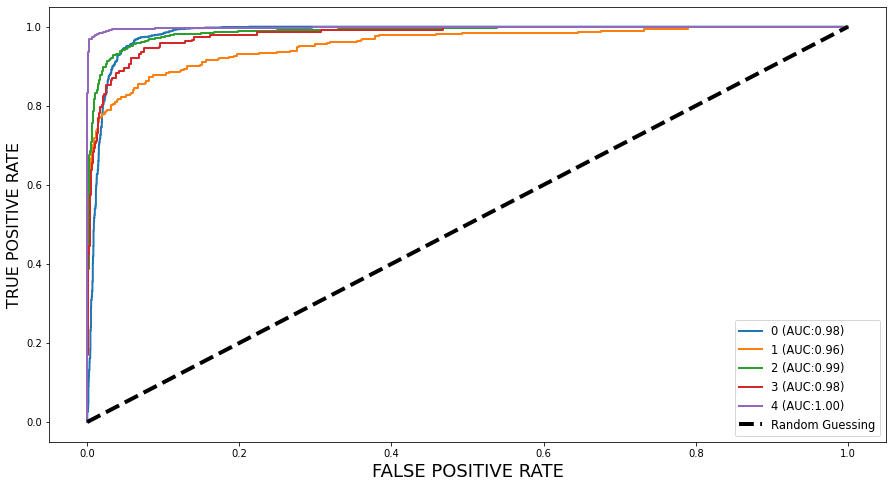

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_true , results1  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
def create_vgg16_model():
    model = Sequential([
    # 1st Conv Block
        Conv1D (filters =64, kernel_size =3, padding ='same',input_shape=(x_train.shape[1],1), activation='relu'),
        Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 2nd Conv Block
        Conv1D (filters =128, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =128, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 3rd Conv block  
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 4th Conv block
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),

    # 5th Conv block
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # Fully connected layers  
        Flatten(),
        Dense(units = 4096, activation ='relu'),
        Dense(units = 4096, activation ='relu'), 
        Dense(units = 5, activation ='softmax')
    ])
    
    return model

vgg16_model = create_vgg16_model()
vgg16_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 187, 64)           256       
                                                                 
 conv1d_5 (Conv1D)           (None, 187, 64)           12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 94, 64)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 94, 128)           24704     
                                                                 
 conv1d_7 (Conv1D)           (None, 94, 128)           49280     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 47, 128)          0         
 1D)                                                 

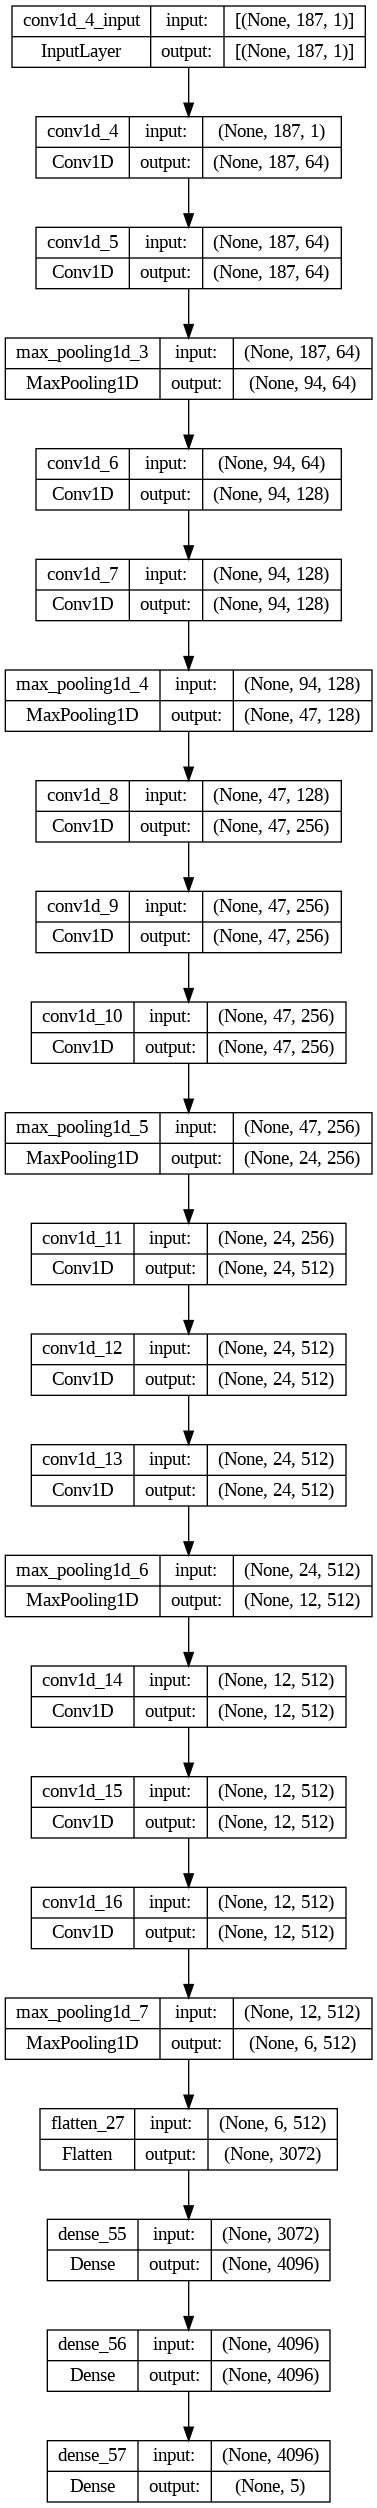

In [ ]:
plot_model(vgg16_model, show_shapes=True, show_layer_names=True)

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='best_weights2.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
vgg16_history = vgg16_model.fit(x=x_train,y= y_train,batch_size=32, epochs=25,callbacks=callbacks, verbose=1, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/25
2053/2053 [==============================] - 49s 24ms/step - loss: 0.4434 - accuracy: 0.8856 - val_loss: 0.1580 - val_accuracy: 0.9571
Epoch 2/25
2053/2053 [==============================] - 45s 22ms/step - loss: 0.1615 - accuracy: 0.9545 - val_loss: 0.1596 - val_accuracy: 0.9583
Epoch 3/25
2053/2053 [==============================] - 46s 23ms/step - loss: 0.1372 - accuracy: 0.9614 - val_loss: 0.1186 - val_accuracy: 0.9666
Epoch 4/25
2053/2053 [==============================] - 47s 23ms/step - loss: 0.1219 - accuracy: 0.9668 - val_loss: 0.1080 - val_accuracy: 0.9707
Epoch 5/25
2053/2053 [==============================] - 44s 22ms/step - loss: 0.1046 - accuracy: 0.9712 - val_loss: 0.2183 - val_accuracy: 0.9713
Epoch 6/25
2053/2053 [==============================] - 44s 22ms/step - loss: 0.1130 - accuracy: 0.9714 - val_loss: 0.1113 - val_accuracy: 0.9711
Epoch 7/25
2053/2053 [==============================] - 47s 23ms/step - loss: 0.0860 - accuracy: 0.9757 - val_loss: 0.0944 -

In [ ]:

from keras.models import load_model
best_model=load_model('best_weights2.h5')
results = best_model.evaluate(x_test,y_test)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

174/174 [==============================] - 2s 10ms/step - loss: 0.2968 - accuracy: 0.9199
Test Loss: 0.29682
Test Accuracy: 91.99%


In [ ]:

results2 = vgg16_model.evaluate(x_test,y_test, verbose=0)

print("     Test Loss: {:.5f}".format(results2[0]))
print(" Test Accuracy: {:.2f}%".format(results2[1] * 100))

     Test Loss: 0.34731
 Test Accuracy: 91.74%


<AxesSubplot:>

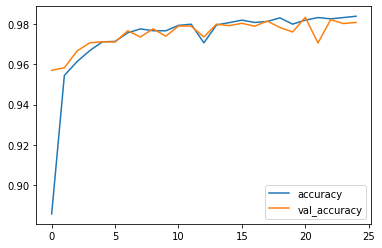

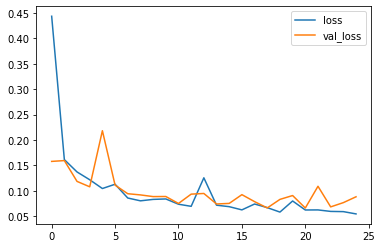

In [ ]:
pd.DataFrame(vgg16_history.history)
pd.DataFrame(vgg16_history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(vgg16_history.history)[['loss', 'val_loss']].plot()

174/174 [==============================] - 1s 5ms/step


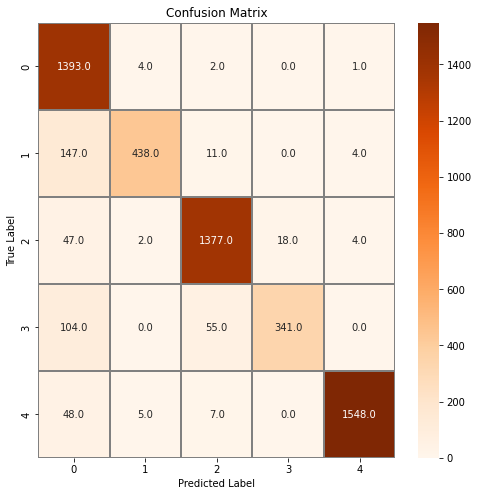

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = vgg16_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:


from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1400
           1       0.98      0.73      0.84       600
           2       0.95      0.95      0.95      1448
           3       0.95      0.68      0.79       500
           4       0.99      0.96      0.98      1608

    accuracy                           0.92      5556
   macro avg       0.93      0.86      0.89      5556
weighted avg       0.93      0.92      0.92      5556



ROC AUC score: 0.9913147512453863


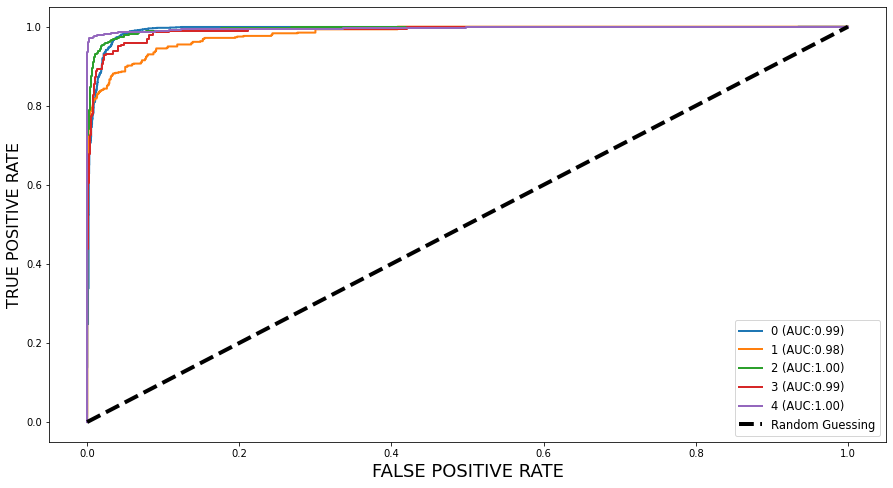

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , Y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
model3=load_model('/content/best_weights2.h5')

In [ ]:
model3=Model(inputs=model3.inputs,outputs=model3.outputs,name='VGG16')

In [ ]:
models=[model1,model2,model3]

In [ ]:
preds=[model.predict(x_test) for model in models]

174/174 [==============================] - 1s 5ms/step


In [ ]:
preds=np.array(preds)

In [ ]:
summed=np.sum(preds,axis=0)

In [ ]:
ensemble_prediction=np.argmax(summed,axis=1)

In [ ]:
ensemble_accuracy=accuracy_score(Y_true,ensemble_prediction)

In [ ]:
print(ensemble_accuracy)

0.9294456443484521


In [ ]:
print(classification_report(Y_true,ensemble_prediction))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1400
           1       0.99      0.76      0.86       600
           2       0.95      0.96      0.95      1448
           3       0.96      0.65      0.78       500
           4       1.00      0.99      0.99      1608

    accuracy                           0.93      5556
   macro avg       0.95      0.87      0.90      5556
weighted avg       0.94      0.93      0.93      5556



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(Y_true,ensemble_prediction) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(Y_true,ensemble_prediction) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
member3 = KerasMember(name="model3", keras_model=model3, train_batches=(x_train,y_train), val_batches=(x_test,y_test))

174/174 [==============================] - 1s 4ms/step


In [ ]:
wAvgEnsemble = DirichletEnsemble(N=10000, metric=accuracy_score)
wAvgEnsemble.add_members([member1, member2,member3])
wAvgEnsemble.fit()
wAvgEnsemble.describe()

model1 - Weight: 0.3500 - accuracy_score: 0.8645
model2 - Weight: 0.4979 - accuracy_score: 0.9386
model1 - Weight: 0.1521 - accuracy_score: 0.9199
DirichletEnsemble accuracy_score: 0.9422


In [ ]:
from sklearn.neighbors import KNeighborsClassifier  
stack = StackEnsemble()

# 2nd Level Meta-Learner
estimators = [
    ('dt', DecisionTreeClassifier(random_state=0, max_depth=3)),
    ('knn',KNeighborsClassifier(n_neighbors=100)),
    ('rf',RandomForestClassifier(verbose=0, n_estimators=100, max_depth=15, n_jobs=20, min_samples_split=30))
]
# 3rd Level Meta-Learner
clf = StackingClassifier(
    estimators=estimators, final_estimator=ExtraTreesClassifier(verbose=0, n_estimators=100, max_depth=10, n_jobs=20, min_samples_split=20)
)

stack.model = clf
stack.add_members([member1, member2, member3])
stack.fit()
stack.describe(metric=sklearn.metrics.accuracy_score)

Calling predict
model1 - accuracy_score: 0.8645
model2 - accuracy_score: 0.9386
model3 - accuracy_score: 0.9199
StackEnsemble accuracy_score: 0.9458


0.9458243340532757

174/174 [==============================] - 3s 8ms/step


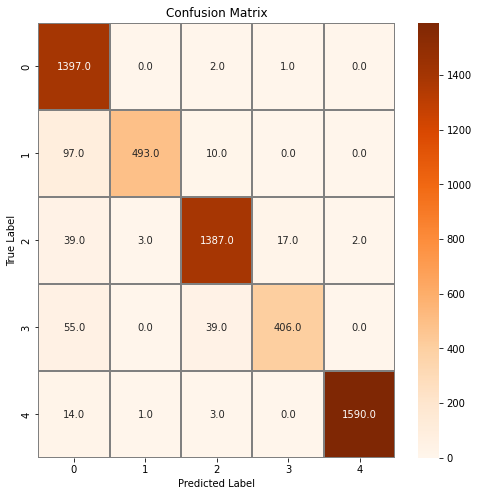

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

Y_pred = stack.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1400
           1       0.99      0.82      0.90       600
           2       0.96      0.96      0.96      1448
           3       0.96      0.81      0.88       500
           4       1.00      0.99      0.99      1608

    accuracy                           0.95      5556
   macro avg       0.96      0.92      0.93      5556
weighted avg       0.95      0.95      0.95      5556



In [ ]:
CLASS_LABELS  = ['0', '1', '2', '3', '4']

ROC AUC score: 0.9960265813724102


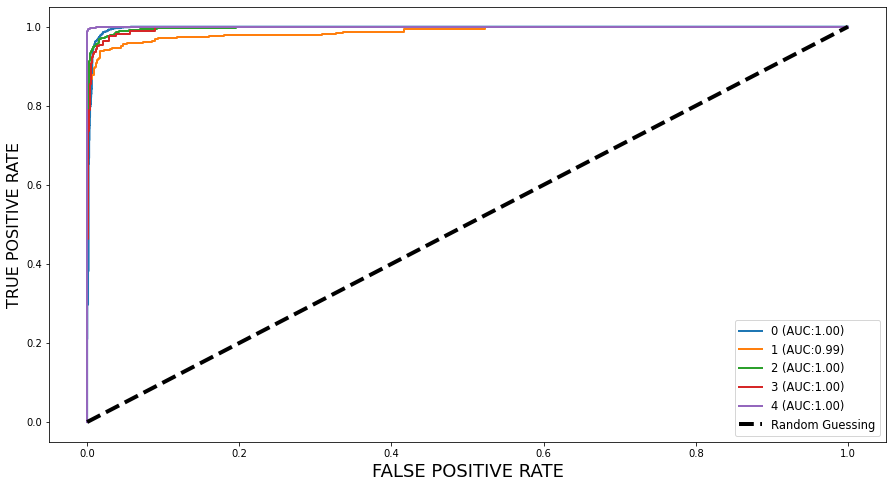

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , Y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
model_input=Input(shape=(x_train.shape[1],1))

In [ ]:
model_outputs=[model(model_input) for model in models]

In [ ]:
from tensorflow.keras.layers import Input, Average,Maximum,Add
ensemble_output=Average()(model_outputs)

In [ ]:
ensemble_model=Model(inputs=model_input,outputs=ensemble_output,name='ensemble')

In [ ]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 Inception (Functional)         (None, 5)            761317      ['input_3[0][0]']                
                                                                                                  
 CNN (Functional)               (None, 5)            223429      ['input_3[0][0]']                
                                                                                                  
 VGG16 (Functional)             (None, 5)            34296133    ['input_3[0][0]']                
                                                                                           

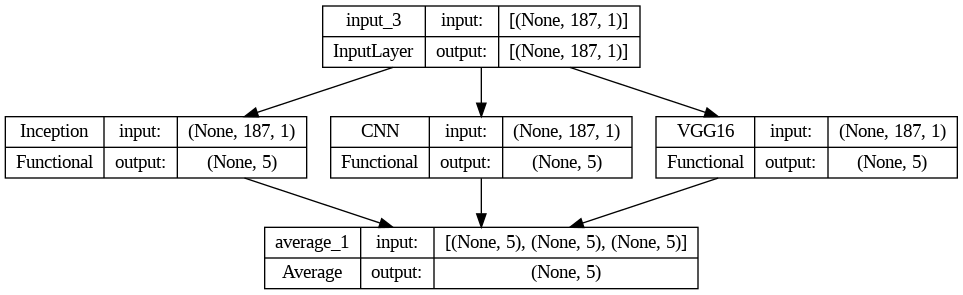

In [ ]:
plot_model(ensemble_model, show_shapes=True, show_layer_names=True)

In [ ]:
ensemble_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=ensemble_model.fit(x_train, y_train,epochs=20, batch_size=32, validation_data=(x_val,y_val))

Epoch 1/20
2053/2053 [==============================] - 161s 63ms/step - loss: 0.0572 - accuracy: 0.9859 - val_loss: 0.1256 - val_accuracy: 0.9800
Epoch 2/20
2053/2053 [==============================] - 127s 62ms/step - loss: 0.0967 - accuracy: 0.9823 - val_loss: 0.1360 - val_accuracy: 0.9778
Epoch 3/20
2053/2053 [==============================] - 122s 59ms/step - loss: 0.0964 - accuracy: 0.9836 - val_loss: 0.1226 - val_accuracy: 0.9790
Epoch 4/20
2053/2053 [==============================] - 122s 60ms/step - loss: 0.0951 - accuracy: 0.9844 - val_loss: 0.1410 - val_accuracy: 0.9752
Epoch 5/20
2053/2053 [==============================] - 128s 62ms/step - loss: 0.0946 - accuracy: 0.9849 - val_loss: 0.1229 - val_accuracy: 0.9816
Epoch 6/20
2053/2053 [==============================] - 125s 61ms/step - loss: 0.0953 - accuracy: 0.9853 - val_loss: 0.1173 - val_accuracy: 0.9834
Epoch 7/20
2053/2053 [==============================] - 122s 59ms/step - loss: 0.0936 - accuracy: 0.9873 - val_loss: 0

In [ ]:
from keras.models import load_model
results1 = ensemble_model.evaluate(x_test,y_test)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

174/174 [==============================] - 3s 15ms/step - loss: 0.5544 - accuracy: 0.9330
    Test Loss: 0.55442
Test Accuracy: 93.30%


Text(0, 0.5, 'loss')

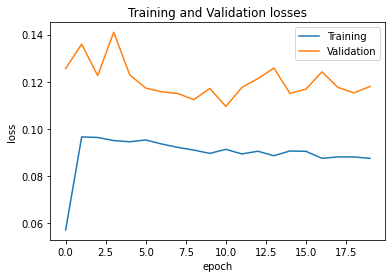

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

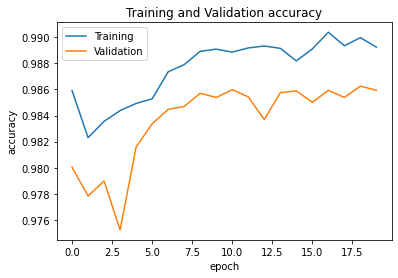

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

174/174 [==============================] - 4s 15ms/step


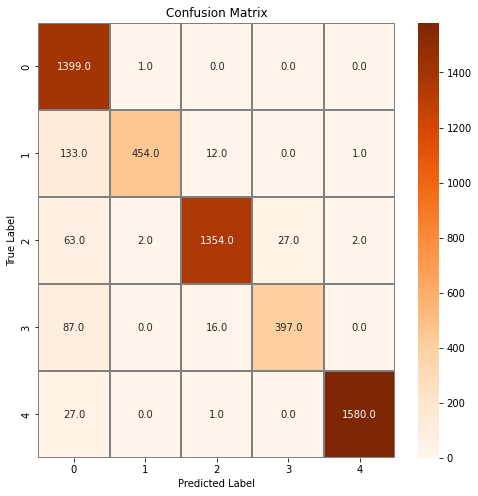

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = ensemble_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1400
           1       1.00      0.78      0.88       600
           2       0.98      0.94      0.96      1448
           3       0.95      0.81      0.87       500
           4       1.00      0.98      0.99      1608

    accuracy                           0.94      5556
   macro avg       0.95      0.90      0.92      5556
weighted avg       0.95      0.94      0.94      5556



ROC AUC score: 0.9807789526405922


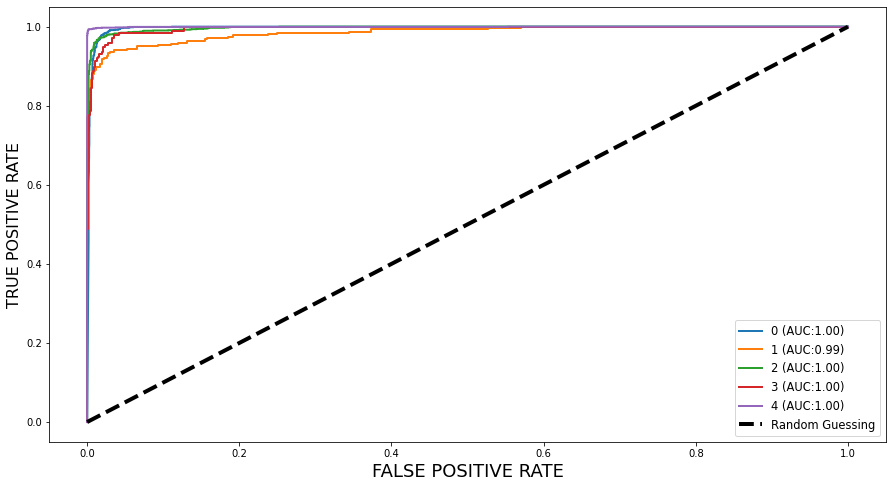

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , Y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
import math
from keras.callbacks import Callback
from keras import backend
from keras.models import load_model

# this callback applies cosine annealing, saves snapshots and allows to load them
class SnapshotEnsemble(Callback):
    
    __snapshot_name_fmt = "snapshot_%d.hdf5"
    
    def __init__(self, n_models, n_epochs_per_model, lr_max, verbose=1):
        """
        n_models -- quantity of models (snapshots)
        n_epochs_per_model -- quantity of epoch for every model (snapshot)
        lr_max -- maximum learning rate (snapshot starter)
        """
        self.n_epochs_per_model = n_epochs_per_model
        self.n_models = n_models
        self.n_epochs_total = self.n_models * self.n_epochs_per_model
        self.lr_max = lr_max
        self.verbose = verbose
        self.lrs = []
 
    # calculate learning rate for epoch
    def cosine_annealing(self, epoch):
        cos_inner = (math.pi * (epoch % self.n_epochs_per_model)) / self.n_epochs_per_model
        return self.lr_max / 2 * (math.cos(cos_inner) + 1)

    # when epoch begins update learning rate
    def on_epoch_begin(self, epoch, logs={}):
        # update learning rate
        lr = self.cosine_annealing(epoch)
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrs.append(lr)

    # when epoch ends check if there is a need to save a snapshot
    def on_epoch_end(self, epoch, logs={}):
        if (epoch + 1) % self.n_epochs_per_model == 0:
            # save model to file
            filename = self.__snapshot_name_fmt % ((epoch + 1) // self.n_epochs_per_model)
            self.model.save(filename)
            if self.verbose:
                print('Epoch %d: snapshot saved to %s' % (epoch, filename))
                
    # load all snapshots after training
    def load_ensemble(self):
        models = []
        for i in range(self.n_models):
            models.append(load_model(self.__snapshot_name_fmt % (i + 1)))
        return models

In [ ]:
se_callback = SnapshotEnsemble(n_models=4, n_epochs_per_model=10, lr_max=.001)

history = ensemble_model.fit(
    x_train, y_train,
    steps_per_epoch=len(x_train) / 64,
    epochs=se_callback.n_epochs_total,
    verbose=1,
    callbacks=[se_callback],
    validation_data=(x_test, y_test)
)

Epoch 1/40
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0806 - accuracy: 0.9923 - val_loss: 0.5701 - val_accuracy: 0.9363
Epoch 2/40
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0813 - accuracy: 0.9921 - val_loss: 0.5953 - val_accuracy: 0.9404
Epoch 3/40
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0798 - accuracy: 0.9933 - val_loss: 0.5852 - val_accuracy: 0.9345
Epoch 4/40
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0800 - accuracy: 0.9928 - val_loss: 0.6110 - val_accuracy: 0.9298
Epoch 5/40
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0787 - accuracy: 0.9931 - val_loss: 0.5949 - val_accuracy: 0.9402
Epoch 6/40
1026/1026 [==============================] - 94s 92ms/step - loss: 0.0775 - accuracy: 0.9942 - val_loss: 0.5935 - val_accuracy: 0.9386
Epoch 7/40
1026/1026 [==============================] - 87s 85ms/step - loss: 0.0765 - accuracy: 0.9947 - val_loss: 0.6130 -

ValueError: ignored

In [ ]:
h = history.history
plt.figure(1, figsize=(16, 10))

plt.subplot(121)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(h['loss'], label='training')
plt.plot(h['val_loss'], label='validation')
plt.legend()

plt.subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(h['acc'], label='training')
plt.plot(h['val_acc'], label='validation')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# makes prediction according to given models and given weights
def predict(models, data, weights=None):
    if weights is None:
        # default weights provide voting equality
        weights = [1 / (len(models))] * len(models)
    pred = np.zeros((data.shape[0], 10))
    for i, model in enumerate(models):
        pred += model.predict(data) * weights[i]
    return pred
    
# returns accuracy for given predictions
def evaluate(preds, weights=None):
    if weights is None:
        weights = [1 / len(preds)] * len(preds)
    y_pred = np.zeros((y_test.shape[0], 10))
    for i, pred in enumerate(preds):
        y_pred += pred * weights[i]
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    return accuracy_score(y_true, y_pred)

# load list of snapshots
models = se_callback.load_ensemble()
# precalculated predictions of all models
preds = []
# evaluate every model as single
for i, model in enumerate(models):
    pred = predict([model], x_test)
    preds.append(pred)
    score = evaluate([pred])
    print(f'model {i + 1}: accuracy = {score:.4f}')

# evaluate ensemble (with voting equality)
ensemble_score = evaluate(preds)
print(f'ensemble: accuracy = {ensemble_score:.4f}')

"from sklearn.metrics import accuracy_score\n\n# makes prediction according to given models and given weights\ndef predict(models, data, weights=None):\n    if weights is None:\n        # default weights provide voting equality\n        weights = [1 / (len(models))] * len(models)\n    pred = np.zeros((data.shape[0], 10))\n    for i, model in enumerate(models):\n        pred += model.predict(data) * weights[i]\n    return pred\n    \n# returns accuracy for given predictions\ndef evaluate(preds, weights=None):\n    if weights is None:\n        weights = [1 / len(preds)] * len(preds)\n    y_pred = np.zeros((y_test.shape[0], 10))\n    for i, pred in enumerate(preds):\n        y_pred += pred * weights[i]\n    y_pred = np.argmax(y_pred, axis=1)\n    y_true = np.argmax(y_test, axis=1)\n    return accuracy_score(y_true, y_pred)\n\n# load list of snapshots\nmodels = se_callback.load_ensemble()\n# precalculated predictions of all models\npreds = []\n# evaluate every model as single\nfor i, model

In [ ]:
'''best_score = ensemble_score
best_weights = None
no_improvements = 0
while no_improvements < 5000: #patience
    
    # generate normalized weights
    new_weights = np.random.uniform(size=(len(models), ))
    new_weights /= new_weights.sum()
    
    # get the score without predicting again
    new_score = evaluate(preds, new_weights)
    
    # check (and save)
    if new_score > best_score:
        no_improvements = 0
        best_score = new_score
        best_weights = new_weights
        print(f'improvement: {best_score:.4f}')
    else:
        no_improvements += 1

print(f'best weights are {best_weights}')'''

"best_score = ensemble_score\nbest_weights = None\nno_improvements = 0\nwhile no_improvements < 5000: #patience\n    \n    # generate normalized weights\n    new_weights = np.random.uniform(size=(len(models), ))\n    new_weights /= new_weights.sum()\n    \n    # get the score without predicting again\n    new_score = evaluate(preds, new_weights)\n    \n    # check (and save)\n    if new_score > best_score:\n        no_improvements = 0\n        best_score = new_score\n        best_weights = new_weights\n        print(f'improvement: {best_score:.4f}')\n    else:\n        no_improvements += 1\n\nprint(f'best weights are {best_weights}')"